In [4]:
import torch
import dill
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams['font.family'] = 'Times New Roman'
    
from src.ode_PINN_hardBC import ODE_PINN_HARDBC
from src.first_order_odesys_PINN_hardBC import ORDER1_ODESYS_PINN_HARDBC
from src.second_order_odesys_PINN_hardBC import ORDER2_ODESYS_PINN_HARDBC
from src.ode_PINN_softBC import ODE_PINN_SOFTBC
from src.ode_PINN_adaptCollectionPoint import  ODE_PINN_AdaptiveCollectionPoint

In [5]:
def Savepickle(obj, doc_path):
    with open(doc_path, 'wb') as file:
        dill.dump(obj, file)     

def Readpickle(doc_path):
    with open(doc_path, 'rb') as file:
        return dill.load(file)
    
def SaveModel(model, path): 
    if model.model_type == 'ODE_PINN_SOFTBC':
        data = {'model_type': model.model_type,
                'f': model.f, 
                'bound' : (model.lb,model.ub),
                'BC' : model.BC , 
                'lambdas' : model.lambdas,
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
    else:
        data = {'model_type': model.model_type,
                'f': model.f, 
                'bound' : (model.lb,model.ub),
                'BC' : model.BC , 
                'n_hidden': model.n_hidden,
                'n_layers': model.n_layers,
                'rff_para': model.rff_para,
                'rff_B'   : model.rff_B,
                'para_dict' : model.state_dict() , 
                'validate_loss' : model.validate_loss,
                'train_loss': model.train_loss,
                'L2_loss': model.L2_loss}
    Savepickle(data, path)
    
def LoadModel(path):
    data = Readpickle(path)
    
    if data['model_type'] == 'ODE_PINN_HARDBC':
        model = ODE_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'])
        
    elif data['model_type'] == 'ODE_PINN_SOFTBC':
        model = ODE_PINN_SOFTBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], lambdas=data['lambdas'],
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'])
        
    elif data['model_type'] == 'ODE_PINN_AdaptiveCollectionPoint':
        model = ODE_PINN_AdaptiveCollectionPoint(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'])
        
    elif data['model_type'] == 'ORDER1_ODESYS_PINN_HARDBC':
        model = ORDER1_ODESYS_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'])
        
    elif data['model_type'] == 'ORDER2_ODESYS_PINN_HARDBC':
        model = ORDER2_ODESYS_PINN_HARDBC(f=data['f'], lb=data['bound'][0], ub=data['bound'][1], BC=data['BC'], 
                                n_hidden=data['n_hidden'], n_layers=data['n_layers'])
     
    model.load_state_dict(data['para_dict'])
    model.validate_loss = data['validate_loss']
    model.train_loss = data['train_loss']
    model.L2_loss = data['L2_loss']
    return model

def moving_average(x, half_window_size):
    res = []
    x = np.array(x)
    for i in range(len(x)):
        if i == 0:
            res.append(x[i]) 
        elif i < half_window_size:
            res.append(x[0:2*i+1].mean())
        elif i <= len(x)-1-half_window_size:
            res.append(x[i-half_window_size:i+half_window_size+1].mean())
        else:
            res.append(x[2*i+1-len(x):].mean())
    return res

# High Frequency Features

In [6]:
f = lambda x , y , D1y:  - (torch.pi)**2*y
true_sol = lambda x :  torch.sin(torch.pi*x)

solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-np.pi), n_hidden=16, n_layers=3)
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.01, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/ode_sin_slover_n1_3layer_16unit.pkl')

------------------------------------------------------- 
-------------------- Epoch [1/5000] -------------------- 
Epoch [1/5000], Step [1/47], Loss: 1303.6852
Epoch [1/5000], Step [9/47], Loss: 921.6166
Epoch [1/5000], Step [18/47], Loss: 861.6320
Epoch [1/5000], Step [27/47], Loss: 272.4565
Epoch [1/5000], Step [36/47], Loss: 60.0038
Epoch [1/5000], Step [45/47], Loss: 30.2157
Epoch [1/5000], Avg. Train Sample Loss: 461.2231, Avg. Validate Sample Loss: 34.1983,                             L2 Loss: 1.5213
------------------------------------------------------- 
-------------------- Epoch [2/5000] -------------------- 
Epoch [2/5000], Step [1/47], Loss: 37.2113
Epoch [2/5000], Step [9/47], Loss: 32.5623
Epoch [2/5000], Step [18/47], Loss: 18.5912
Epoch [2/5000], Step [27/47], Loss: 15.8298
Epoch [2/5000], Step [36/47], Loss: 15.6463
Epoch [2/5000], Step [45/47], Loss: 22.2101
Epoch [2/5000], Avg. Train Sample Loss: 23.3300, Avg. Validate Sample Loss: 17.5776,                           

KeyboardInterrupt: 

In [ ]:
f = lambda x , y , D1y:  - (5*torch.pi)**2*y
true_sol = lambda x :  torch.sin(5*torch.pi*x)

solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi), n_hidden=16, n_layers=3)   ###
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/ode_sin_slover_n5_3layer_16unit.pkl')


solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi), n_hidden=16, n_layers=5)    ###
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/ode_sin_slover_n5_5layer_16unit.pkl')


solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi), n_hidden=32, n_layers=5)    ###
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/ode_sin_slover_n5_5layer_32unit.pkl')


solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi), n_hidden=64, n_layers=5)    
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/ode_sin_slover_n5_5layer_64unit.pkl')

 
solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi),                             ###
                         n_hidden=16, n_layers=3, set_rff=True, rff_num=8, u=0, std=1)
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/rff_ode_sin_slover_n5_3layer_16unit.pkl')


solver = ODE_PINN_AdaptiveCollectionPoint( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi), n_hidden=64, n_layers=5) ##
solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
SaveModel(solver,'./data/adp_ode_sin_slover_n5_5layer_64unit.pkl')

In [ ]:
# f = lambda x , y , D1y:  - (5*torch.pi)**2*y
# true_sol = lambda x :  torch.sin(5*torch.pi*x)

# solver = ODE_PINN_HARDBC( f=f, lb=-1, ub=1, BC=(2,0,-5*np.pi),                             #
#                          n_hidden=16, n_layers=3, set_rff=True, rff_num=8, u=0, std=1)
# solver.Train(train_num=3000, train_batch_size=64, learning_rate=0.001, 
#              lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
#              abs_tolerance=1e-4, max_epoch=5000, compute_L2_loss=True, true_sol=true_sol)
# #SaveModel(solver,'./data/rff_ode_sin_slover_n5_3layer_16unit.pkl')


# fig  = plt.figure(figsize = (14,5))
# true_sol = lambda x:  torch.sin(5*torch.pi*x)
# x = torch.linspace(-1,1,200).view(-1,1)
# x_grid = x.squeeze().detach().numpy()

# plt.subplot(1,2,1)
# y_gt = true_sol(x).squeeze().detach().numpy()
# y_hat = solver(x).squeeze().detach().numpy()
# plt.plot(x_grid, y_gt, linewidth=2)
# plt.plot(x_grid, y_hat, linewidth=2)

# plt.subplot(1,2,2)
# loss = np.log10(solver.L2_loss)
# plt.plot(loss, linewidth=2)

## Visualize

In [ ]:
paths = [ './data/ode_sin_slover_n1_3layer_16unit.pkl',
          './data/ode_sin_slover_n5_3layer_16unit.pkl',
          './data/ode_sin_slover_n5_5layer_16unit.pkl',
          './data/ode_sin_slover_n5_5layer_32unit.pkl',
          './data/rff_ode_sin_slover_n5_3layer_16unit.pkl' ]

solvers = [LoadModel(path) for path in paths]

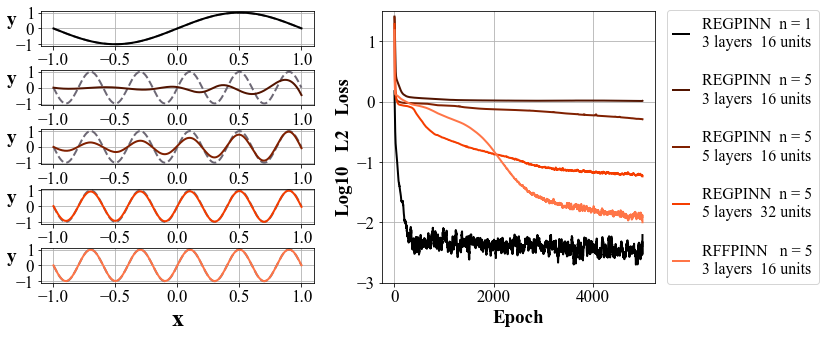

In [ ]:
title_fontsize , tick_size , leg_size = 19, 17, 16
fig  = plt.figure(figsize = (11,5))
# color   = ['#2e2a79', '#473477', '#915270', '#C25371', '#E94220', '#6d6875']
# color   = ['#c1121f', '#802000','#003049','#386641','#6a4c93', '#6d6875']
color   = ['#000000', '#521400', '#802000', '#F53D00', '#FF7547', '#6d6875']
# color   = ["#0d0c1d","#161b33", "#474973", '#a69cac', '#f1dac4', '#6d6875']

legend  = ['REGPINN  n = 1\n3 layers  16 units',
           'REGPINN  n = 5\n3 layers  16 units',
           'REGPINN  n = 5\n5 layers  16 units',
           'REGPINN  n = 5\n5 layers  32 units',
           'RFFPINN   n = 5\n3 layers  16 units',]


ax_fit  = [plt.subplot(521), plt.subplot(523), plt.subplot(525), plt.subplot(527), plt.subplot(529)]
ax_loss = plt.subplot(122)

true_sol_1 = lambda x:  torch.sin(torch.pi*x)
true_sol_2 = lambda x:  torch.sin(5*torch.pi*x)
x = torch.linspace(-1,1,200).view(-1,1)
x_grid = x.squeeze().detach().numpy()

for i in range(5):
    if i == 0:
        y_gt = true_sol_1(x).squeeze().detach().numpy()
    else:
        y_gt = true_sol_2(x).squeeze().detach().numpy()
    y_hat = solvers[i](x).squeeze().detach().numpy()

    ax_fit[i].plot(x_grid, y_gt, color=color[-1], linewidth=2, linestyle='--')
    ax_fit[i].plot(x_grid, y_hat, color=color[i], linewidth=2, label=legend[i])
    ax_fit[i].grid()
    
    half_window_size = 10
    loss = np.log10(solvers[i].L2_loss)
    loss = moving_average(loss, half_window_size)
    ax_loss.plot(loss, color=color[i], linewidth=2, label=legend[i])
    
    ax_fit[i].tick_params(axis='x', labelsize=tick_size)
    ax_fit[i].tick_params(axis='y', labelsize=tick_size)
    
    if i == 4 :
        ax_fit[i].set_xlabel('x', fontsize=title_fontsize+5, fontweight='bold')
    ax_fit[i].set_ylabel('y', fontsize=title_fontsize, fontweight='bold', rotation=0)
    
ax_loss.grid()
ax_loss.set_ylim(-3, 1.5)
ax_loss.tick_params(axis='x', labelsize=tick_size)
ax_loss.tick_params(axis='y', labelsize=tick_size)

leg = ax_loss.legend(loc='center right', bbox_to_anchor=(1.63, 0.5), 
                     fontsize=leg_size, handlelength=1.0, labelspacing=1.4)

ax_loss.set_ylabel('Log10   L2   Loss', fontsize=title_fontsize, fontweight='bold')
ax_loss.set_xlabel('Epoch', fontsize=title_fontsize, fontweight='bold')

plt.subplots_adjust(wspace=0.25, hspace=0.7)
plt.show()

# Other ODE Examples

In [ ]:
# BC 1 Examples Training
f1 = lambda x , y , D1y : -y
f2 = lambda x , y , D1y : y ** 2 - 2 - (1+x*(1-x))**2
f3 = lambda x , y , D1y : y
f4 = lambda x , y , D1y:  torch.exp(x) * ( ( 1 - 16*torch.pi**2 ) * torch.sin(4*torch.pi*x) + 8*torch.pi*torch.cos(4*torch.pi*x) )
fs = [f1, f2, f3, f4]

y_true1 = lambda x : torch.sin(x)
y_true2 = lambda x : 1 + x * ( 1 - x )
y_true3 = lambda x : torch.exp(x)
y_true4 = lambda x : torch.exp(x) * torch.sin(4*torch.pi*x) 
y_trues = [y_true1, y_true2, y_true3, y_true4]

BCs = [(1,0,np.sin(1)) , (1,1,1) , (1,1,np.exp(1)) , (1,0,0)]

# Initialize models
models = [ ODE_PINN_HARDBC( f=fs[i], lb=0, ub=1, BC=BCs[i], n_hidden=50, n_layers=3) for i in range(4) ] 

## Training
for i in range(4):
    print('start training model %d'%(i+1))
    torch.manual_seed(100)  
    models[i].Train(train_num=1000, train_batch_size=32, learning_rate=0.01, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=0, max_epoch=200, compute_L2_loss=True, true_sol=y_trues[i], display=False)
#     SaveModel(models[i], './data/ode_slover_BC1exp%d.pkl'%(i+1))
# Savepickle(y_trues, './data/ode_slover_BC1exp_gt.pkl')  

start training model 1
start training model 2
start training model 3
start training model 4


In [ ]:
# BC 2 Examples Training
f1 = lambda x , y , D1y : - y * ( y**2 + D1y**2 )
f2 = lambda x , y , D1y : - 2 * x * D1y - 2 * y
f3 = lambda x , y , D1y :  1 - D1y**2
f4 = lambda x , y , D1y :  -y
fs = [f1, f2, f3, f4]

y_true1 = lambda x : torch.cos(x)
y_true2 = lambda x : 2 * torch.exp(-x**2)
y_true3 = lambda x : torch.log( (torch.exp(x)+torch.exp(-x))/2 ) 
y_true4 = lambda x : torch.sin(x)
y_trues = [y_true1, y_true2, y_true3, y_true4]

BCs = [(2, 1, -np.sin(1)), (2, 2, -4*np.exp(-1)), 
       (2, 0, (np.exp(1) - np.exp(-1))/(np.exp(1) + np.exp(-1))), 
       (2, 0, np.cos(1))]

# Initialize models
models = [ ODE_PINN_HARDBC( f=fs[i], lb=0, ub=1, BC=BCs[i], n_hidden=50, n_layers=3) for i in range(4) ] 

## Training
for i in range(4):
    print('start training model %d'%(i+1))
    torch.manual_seed(100)  
    models[i].Train(train_num=1000, train_batch_size=32, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=0, max_epoch=100, compute_L2_loss=True, true_sol=y_trues[i], display=False)
#     SaveModel(models[i], './data/ode_slover_BC2exp%d.pkl'%(i+1))
# Savepickle(y_trues, './data/ode_slover_BC2exp_gt.pkl')  

start training model 1
start training model 2
start training model 3
start training model 4


In [ ]:
# BC 3 Examples Training
f1 = lambda x , y , D1y : - y * ( y**2 + D1y**2 )
f2 = lambda x , y , D1y : - 2 * x * D1y - 2 * y
f3 = lambda x , y , D1y :  1 - D1y**2
f4 = lambda x , y , D1y :  -y
fs = [f1, f2, f3, f4]

y_true1 = lambda x : torch.cos(x)
y_true2 = lambda x : 2 * torch.exp(-x**2)
y_true3 = lambda x : torch.log( (torch.exp(x)+torch.exp(-x))/2 ) 
y_true4 = lambda x : torch.sin(x)
y_trues = [y_true1, y_true2, y_true3, y_true4]

BCs = [(3,1,-np.sin(1)), (3,2,-4*np.exp(-1)), 
       (3,0, (np.exp(1) - np.exp(-1))/(np.exp(1) + np.exp(-1)) ), 
       (3, 1, np.cos(1))]

# Initialize models
models = [ ODE_PINN_HARDBC( f=fs[i], lb=0, ub=1, BC=BCs[i], n_hidden=50, n_layers=3) for i in range(4) ] 

## Training
for i in range(4):
    print('start training model %d'%(i+1))
    torch.manual_seed(100)  
    models[i].Train(train_num=1000, train_batch_size=32, learning_rate=0.001, 
             lr_step_size=100, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=0, max_epoch=100, compute_L2_loss=True, true_sol=y_trues[i], display=False)
#     SaveModel(models[i], './data/ode_slover_BC3exp%d.pkl'%(i+1))
# Savepickle(y_trues, './data/ode_slover_BC3exp_gt.pkl')  

start training model 1
start training model 2
start training model 3
start training model 4


In [ ]:
# BC 1 ODESYS Examples Training
f = lambda x , y , D1y : torch.cat( ( x * y[:,0].unsqueeze(1) - y[:,1].unsqueeze(1) - 2 - x - (torch.pi/2)**2 * torch.sin(torch.pi*x/2), 
                                      y[:,1].unsqueeze(1) - 6 * x + 2 - x**2 * (1-x) ), dim=1)
y_true = lambda x : torch.cat( (x*(1-x)+torch.sin(torch.pi*x/2), x**2*(1-x) ), dim=1)

model = ORDER2_ODESYS_PINN_HARDBC( f=f, lb=0, ub=1, BC=(1,[0,0],[1,0]), n_hidden=50, n_layers=3)
model.Train(train_num=2000, train_batch_size=32, learning_rate=0.001, lr_step_size=1000, min_lr =1e-10, lr_gamma=0.5,
             abs_tolerance=0, max_epoch=100, compute_L2_loss=True, true_sol=y_true, display=True)
# SaveModel(model, './data/odesys_slover_exp.pkl')
# Savepickle(y_true, './data/odesys_slover_exp_gt.pkl') 

## Visualize

In [ ]:
data = []

for k in range(4):

    if k==3 :
        model  = LoadModel('./data/odesys_slover_exp.pkl')
        y_true = Readpickle('./data/odesys_slover_exp_gt.pkl')
        data.append((model, y_true))
    else:
        paths   = [ './data/ode_slover_BC%dexp%d.pkl'%(k+1,i+1) for i in range(4) ]
        models  = [LoadModel(path) for path in paths]
        y_trues = Readpickle('./data/ode_slover_BC%dexp_gt.pkl'%(k+1))
        data.append((models, y_trues))
    

true_names_lst  = [['$y_1$', '$y_2$', '$y_3$', '$y_4$'],
                   ['$y_5$', '$y_6$', '$y_7$', '$y_8$'],
                   ['$y_5$', '$y_6$', '$y_7$', '$y_8$'],
                   ['$u$', '$v$']]

model_names_lst = [['$y_1$ PINN', '$y_2$ PINN', '$y_3$ PINN', '$y_4$ PINN'],
                   ['$y_5$ PINN', '$y_6$ PINN', '$y_7$ PINN', '$y_8$ PINN'],
                   ['$y_5$ PINN', '$y_6$ PINN', '$y_7$ PINN', '$y_8$ PINN'],
                   ['$u$ PINN', '$v$ PINN']]

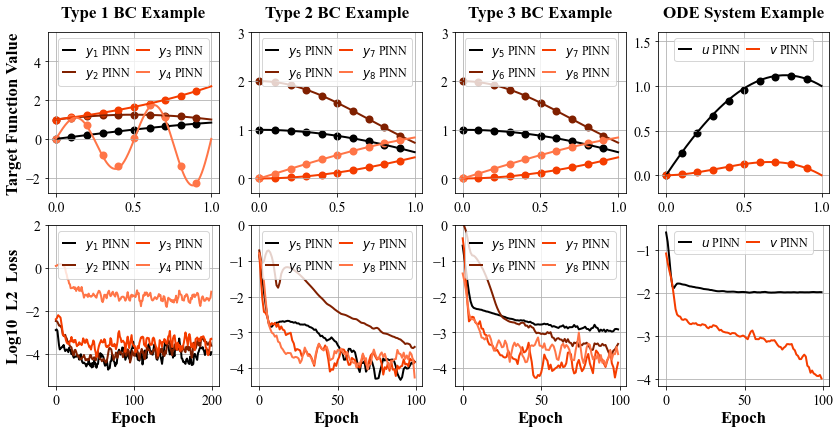

In [ ]:
## Plot loss changes
fig, axes = plt.subplots( 2 , 4 , figsize=( 14, 6.5 ) )
title_fontsize = 17
tick_size = 14
leg_size = 12
half_window_size = 1

PINNColor  = ['#000000','#802000','#F53D00','#FF7547']
PINNColor2  = ['#000000','#F53D00']

# PINNColor   = ["#161b33", "#474973", '#a69cac', '#f1dac4']
# PINNColor2  = ["#161b33", "#474973"]

titles = ['Type 1 BC Example', 'Type 2 BC Example', 'Type 3 BC Example', 'ODE System Example']

for k in range(4):
    
    true_names = true_names_lst[k]
    model_names = model_names_lst[k]
    models , y_trues = data[k]
    
    x = torch.linspace(0,1,200).view(-1,1)
    if k < 3:
        y_trues_ = [ y_trues[i](x).squeeze().detach().numpy() for i in range(4) ]
        y_hats_  = [ models[i](x).squeeze().detach().numpy()  for i in range(4) ]
    else:
        y_trues_ = y_trues(x).detach().numpy()
        y_hats_  = models(x).detach().numpy()
    x = x.squeeze().detach().numpy()
    
    num_lines = []
    if k < 3:
        for i in range(4):
            # Fitting
            axes[0,k].scatter(x[::20], y_trues_[i][::20] , linewidth=2, label=true_names[i], color=PINNColor[i])
            num_line, = axes[0,k].plot(x, y_hats_[i], linewidth=2, label=model_names[i], color=PINNColor[i])
            num_lines.append(num_line) 
            
            # Loss
            loss = np.log10(models[i].L2_loss)[:]
            loss = moving_average(loss, half_window_size)
            axes[1,k].plot(loss, linewidth=2, label=model_names[i], color=PINNColor[i])
    else:
        for i in range(2):
            # Fitting
            axes[0,k].scatter(x[::20], y_trues_[:,i][::20] , linewidth=2, label=true_names[i], color=PINNColor2[i])
            num_line, = axes[0,k].plot(x, y_hats_[:,i], linewidth=2, label=model_names[i], color=PINNColor2[i])
            num_lines.append(num_line) 
            
            # Loss
            loss = np.log10([loss_[i] for loss_ in models.L2_loss])[:]
            loss = moving_average(loss, half_window_size)
            axes[1,k].plot(loss, linewidth=2, label=model_names[i], color=PINNColor2[i])
            
    # Legend         
    axes[0,k].legend(handles=num_lines, handlelength=1, loc='upper center', labelspacing=0.5, columnspacing=0.5,
                        fontsize=leg_size, ncol=2, fancybox=True)
    axes[1,k].legend(loc='upper center', handlelength=1, labelspacing=0.5, columnspacing=0.5,
                        fontsize=leg_size, ncol=2, fancybox=True)

    # Grid & y_lim
    axes[0,k].grid()
    axes[1,k].grid()    
    
    if k == 0:
        axes[0,k].set_ylim(-2.8, 5.5)
        axes[1,k].set_ylim(-5.5, 2)
    elif k == 1 or k == 2:
        axes[0,k].set_ylim(-0.3, 3)
        axes[1,k].set_ylim(-4.5, 0)
    else:
        axes[0,k].set_ylim(-0.2, 1.6)
        
    # xy axes and title
    axes[0,k].tick_params(axis='x', labelsize=tick_size)
    axes[0,k].tick_params(axis='y', labelsize=tick_size)
    axes[1,k].tick_params(axis='x', labelsize=tick_size)
    axes[1,k].tick_params(axis='y', labelsize=tick_size)
    
    axes[0,k].set_title(titles[k], fontsize=title_fontsize, fontweight='bold', pad=15) 
    axes[1,k].set_xlabel('Epoch', fontsize=title_fontsize, fontweight='bold') 

axes[0,0].set_ylabel('Target Function Value', fontsize=title_fontsize, fontweight='bold') 
axes[1,0].set_ylabel('Log10  L2  Loss', fontsize=title_fontsize, fontweight='bold') 

plt.subplots_adjust(wspace=0.19, hspace=0.2)
plt.show()